# Computer Lab: nonnegative matrix factorization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
import time

def build_matrix_from_faces(folder='orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
Uncompress the file.

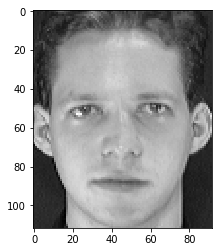

In [5]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='./orl_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

# Full data
# M = build_matrix_from_faces(folder='./att_faces/orl_faces', minidata=False)
# def unvectorize(W_H): return unvectorize_M(W_H, M)
# k = 38

# initialization
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)
n, p = M.shape

## 1 Database
### Question 1.1
There are ten different images of each of 40 distinct subjects. So there are 400 images in the database. The size of each image is 92x112 pixels, with 256 grey levels per pixel. So there are 10304 pixels in each image.

## 2 Presentation of the model
### Question 2.1
#### Show that the objective function is not convex. 
The objective function is $$ L\left(W,H\right)=\frac{1}{2np}||M-WH||_{F}^{2}. $$
In order to show that it's not convex, we need to find a counterexample. We consider the case where $ n=k=p=1 $. Our counterexample is $$ M=1, W_{1}=1, H_{1}=2, W_{2}=2, H_{1}=1, $$ 
$$ L\left(W_{1},H{1}\right)=\frac{1}{2\times1\times1}\times\left(1-1\times2\right)^{2}=\frac{1}{2}, $$
$$ L\left(W_{2},H{2}\right)=\frac{1}{2\times1\times1}\times\left(1-2\times1\right)^{2}=\frac{1}{2}, $$
$$ L\left(\frac{W_{1}+H_{1}}{2},\frac{W_{2}+H_{2}}{2}\right)=\frac{1}{2\times1\times1}\times\left(1-\frac{3}{2}\times\frac{3}{2}\right)^{2} = \frac{25}{32}, $$
$$ \frac{1}{2}\left(L\left(W_{1},H_{1}\right)+L\left(W_{2},H_{2}\right)\right)<L\left(\frac{W_{1}+H_{1}}{2},\frac{W_{2}+H_{2}}{2}\right). $$
Therefore, the objective function is not convex.
#### Caculate its gradient.
$$
\begin{equation}
\begin{aligned}
L\left(W+\Delta W, H\right)
&=\frac{1}{2np}||M-\left(W+\Delta W\right)H||_{F}^{2}\\
&=\frac{1}{2np}tr\left(\left(M^{T}-H^{T}W^{T}-H^{T}\Delta W^{T}\right)\left(M-WH-\Delta WH\right)\right)\\
&=\frac{1}{2np}tr\left(M^{T}M-H^{T}W^{T}M-H^{T}\Delta W^{T}M-M^{T}WH+H^{T}W^{T}WH+H^{T}\Delta W^{T}WH-M^{T}\Delta WH+H^{T}W^{T}\Delta WH+H^{T}\Delta W^{T}\Delta WH\right)\\
&=\frac{1}{2np}\left(tr\left(\left(M-WH\right)^{T}\left(M-WH\right)\right)-2tr\left(H^{T}\Delta W^{T}\left(M-WH\right)\right)+H^{T}\Delta W^{T}\Delta WH\right)\\
&\approx L\left(W, H\right)-\frac{1}{np}tr\left(H^{T}\Delta W^{T}\left(M-WH\right)\right)
\end{aligned}	
\end{equation}
$$
Therefore, $\nabla_{W}L\left(W,H\right)=-\frac{1}{np}(M-WH)H^{T}.$ <br>
Similarly, we have$\nabla_{H}L\left(W,H\right)=-\frac{1}{np}W^{T}(M-WH).$
#### Is the gradient Lipschitz continuous?
No, it isn't, because the gradient is a polynomial of degree 3 and none of polynomials whose degree is bigger than 1 is Lipschitz continuous.

## 3 Find $W$ when $H_{0}$ is fixed
### Question 3.1
#### What is the advantage of this choice?
scipy.sparse.linalg.svds returns the largest k singular values/vectors for a sparse matrix, which allows to reconstruct approximately M with a low complexity and a small k. numpy.maximum(0, W0 * numpy.sqrt(S)) and numpy.maximum(0,(H0.T * numpy.sqrt(S)).T) ensure that all the coefficients of $W_{0}$ and $H_{0}$ are non-negative.
#### What would be other possibilities for the initialization?
We can initialize them by 0 or by random values which are 0 or positive.

### Question 3.2
#### Is the objective function g convex?
According to Question 2.1, we have
$$
\begin{equation}
\begin{aligned}
g\left(W+\Delta W\right)
&=\frac{1}{2np}\left(tr\left(\left(M-WH_{0}\right)^{T}\left(M-WH_{0}\right)\right)-2tr\left(H_{0}^{T}\Delta W^{T}\left(M-WH_{0}\right)\right)+H_{0}^{T}\Delta W^{T}\Delta WH_{0}\right)\\
&= g\left(W\right)-\frac{1}{np}tr\left(H_{0}^{T}\Delta W^{T}\left(M-WH_{0}\right)\right)+\frac{1}{2np}H_{0}^{T}\Delta W^{T}\Delta WH_{0}\\
\end{aligned}	
\end{equation}
$$
So we obtain $ \nabla^{2}g\left(W\right) = \frac{1}{np}H_{0}H_{0}^{T} $ which is positive semi-definite. Therefore, the objective function g is convex.
#### Calculate its gradient
It's similar to Question 2.1. We have $\nabla g\left(W\right)=-\frac{1}{np}(M-WH_{0})H_{0}^{T}.$

### Question 3.3

In [6]:
def val_g(W_vectorized):
    W = W_vectorized.reshape((n, k))
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H0), ord='fro')**2

def grad_g(W_vectorized):
    W = W_vectorized.reshape((n, k))
    grad = -1/(n*p)*np.dot(M-np.dot(W, H0), H0.T)
    return grad.ravel()

print (scipy.optimize.check_grad(val_g, grad_g, W0.ravel()))
    

0.00010928003465056223


### Question 3.4
$$ prox_{\gamma \iota_{\mathbb{R}_{+}}}(x)= \mathop{\arg\min}_{y\in R} \gamma\iota_{\mathbb{R}_{+}}\left(y\right)+\frac{1}{2}||y-x||^{2} $$
We have a constraint on y, $y \geq 0.$
$$ x \geq 0, y \geq 0, y = x $$
$$ x < 0, y \geq 0, y = 0 $$
Therefore, for all $\gamma$ > 0, $prox_{\gamma \iota_{\mathbb{R}_{+}}}$ is the projection onto $\mathbb{R}_{+}$.
### Question 3.5
### Question 3.6

gamma: 2.2226786924357986
time: 0.35977959632873535s
Question 3.6: for N = 100, g = 435.62287011493095


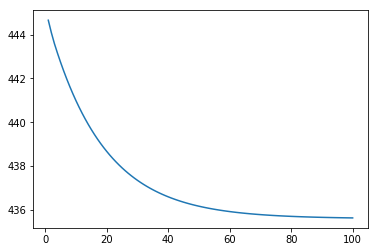

In [7]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    W = W0.ravel()
    g_evolution = []
    for i in range(N):
        W = np.maximum(0, W - gamma*grad_g(W))
        g_evolution.append(val_g(W))
    return W, val_g(W), g_evolution
gamma = n*p/np.linalg.norm(np.dot(H0.T, H0), ord='fro')
print ("gamma: " + str(gamma))

t1 = time.time()
W, g, g_evolution = projected_gradient_method(val_g, grad_g, W0, gamma, 100)
t2 = time.time()
print ("time: " + str(t2-t1) + "s")
print ("Question 3.6: for N = 100, g = "+ str(g))
x = np.arange(1, 101)
plt.plot(x, g_evolution)
                                              

## 4 Algorithmic refinement for the problem with $H_{0}$ fixed
### Question 4.1

time: 1.7119460105895996s
435.61263552864966


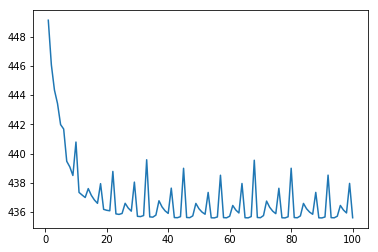

In [8]:
def armijo_line_search_projected_gradient_method(val_g, grad_g, W0, N):
    W = W0.ravel()
    a, gamma, beta = 0.5, 0.5, 0.5
    b = 0.5
    g_evolution = []
    for i in range(N):
        l = 0
        while (val_g(W - b*(a**l)*grad_g(W)) >  val_g(W) + beta*(-b*(a**l))*np.linalg.norm(grad_g(W))**2):
            l+=1
        W = np.maximum(0, W - b*(a**l)*grad_g(W))
        b = 2*b*(a**l)
        g_evolution.append(val_g(W))
    return W, val_g(W), g_evolution

t1 = time.time()
W, g, g_evolution = armijo_line_search_projected_gradient_method(val_g, grad_g, W0, 100)
t2 = time.time()
print ("time: " + str(t2-t1) + "s")
print (g)
x = np.arange(1, 101)
plt.plot(x, g_evolution)

### Question 4.2
In terms of efficiency, the line search method takes much more time to converge than the constant step method (0.16s VS 0.03s) with the same number of iterations, because it needs more time to compute each step. <br>
In terms of accuracy, the two methods obtain almost the same results after 100 iterations. But the value of the objective function of the line search method doesn't decrease monotonically. This is because unlike the general line search, here we have to project W to the constraint in order to ensure it's non-negative. We can attenuate this effect by reducing b of the line search parameters. <br>
The constant step method has a better performance. However, it's not always possble to have the Lipschitz constant. <br>

## 5 Resolution of the full problem
### Question 5.1

time: 26.8674578666687s
solution of W_H_vectorized: [ 8.32243387 71.94176671  0.         ...  0.56303967  0.58494943
  0.58634379]
objective value: 357.8585436267224


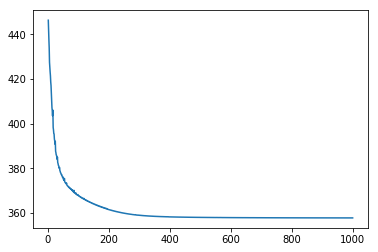

In [9]:
def val_L(W_H_vectorized):
    W, H = unvectorize(W_H_vectorized)
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H))**2

def grad_L(W_H_vectorized):
    W, H = unvectorize(W_H_vectorized)
    grad_W = -1/(n*p)*np.dot(M-np.dot(W, H), H.T)
    grad_H = -1/(n*p)*np.dot(W.T, M-np.dot(W, H))
    return vectorize(grad_W, grad_H)

# print (scipy.optimize.check_grad(val_L, grad_L, vectorize(W0, H0)))
# print (armijo_line_search_projected_gradient_method(val_L, grad_L, vectorize(W0, H0), 10000))
t1 = time.time()
W, L, L_evolution = armijo_line_search_projected_gradient_method(val_L, grad_L, vectorize(W0, H0), 1000)
t2 = time.time()
print ("time: " + str(t2-t1) + "s")
print ("solution of W_H_vectorized: " + str(W))
print ("objective value: " + str(L))
x = np.arange(1, 1001)
plt.plot(x, L_evolution)

### Question 5.2 
Show that the value of the objective is decreasing at each iteration. Deduce from this
that the value converges. <br>
For each iteration, since $$ W_{t} = argmin_{W} \frac{1}{2np}||M-WH_{t-1}||_{F}^{2} $$ and $$ H_{t} = argmin_{H}\frac{1}{2np}||M-W_{t}H||_{F}^{2},$$ we have $$ \frac{1}{2np}||M-W_{t-1}H_{t-1}||_{F}^{2} \geq \frac{1}{2np}||M-W_{t}H_{t-1}||_{F}^{2}  \geq \frac{1}{2np}||M-W_{t}H_{t}||_{F}^{2} .$$ So the value of the objective is decreasing at each iteration. And we know that the objective function $ L \geq 0 $. So this value converges eventually.
### Question 5.3

time: 28.72331404685974s
solution of W_H_vectorized: [ 9.38506882 69.69104196  0.         ...  0.5861613   0.60830803
  0.61007121]
objective value: 357.88274793452376


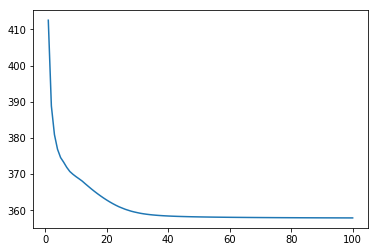

In [10]:
def val_g_alternate(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H), ord='fro')**2

def grad_g_alternate(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    grad = -1/(n*p)*np.dot(M-np.dot(W, H), H.T)
    return grad.ravel()

def armijo_line_search_projected_gradient_method_W(val_g_alternate, grad_g_alternate, H_vectorized, W0_vectorized, N):
    W = W0_vectorized
    a, gamma, beta = 0.5, 0.5, 0.5
    b = 1
    for i in range(N):
        l = 0
        while (val_g_alternate(W-b*(a**l)*grad_g_alternate(W, H_vectorized), H_vectorized) 
               > val_g_alternate(W, H_vectorized) + beta*(-b*(a**l))*np.linalg.norm(grad_g_alternate(W, H_vectorized))**2):
            l+=1
        W = np.maximum(0, W - b*(a**l)*grad_g_alternate(W, H_vectorized))
        b = 2*b*(a**l)
    return W, val_g_alternate(W, H_vectorized)

# print (armijo_line_search_projected_gradient_method_W(val_g_alternate, grad_g_alternate, H0.ravel(), W0.ravel(), 100))

def val_h_alternate(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H), ord='fro')**2

def grad_h_alternate(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    grad = -1/(n*p)*np.dot(W.T, M-np.dot(W, H))
    return grad.ravel()

def armijo_line_search_projected_gradient_method_H(val_h_alternate, grad_h_alternate, H0_vectorized, W_vectorized, N):
    H = H0_vectorized
    a, gamma, beta = 0.5, 0.5, 0.5
    b = 1
    for i in range(N):
        l = 0
        while (val_h_alternate(W_vectorized, H-b*(a**l)*grad_h_alternate(W_vectorized, H)) 
               > val_h_alternate(W_vectorized, H) + beta*(-b*(a**l))*np.linalg.norm(grad_h_alternate(W_vectorized, H))**2):
            l+=1
        H = np.maximum(0, H - b*(a**l)*grad_h_alternate(W_vectorized, H))
        b = 2*b*(a**l)
    return H, val_h_alternate(W_vectorized, H)

def alternate_minimizations_method(N, M):
    W, H = W0.ravel(), H0.ravel()
    evolution = []
    for i in range(M):
        W = armijo_line_search_projected_gradient_method_W(val_g_alternate, grad_g_alternate, H, W, N)[0]
        H = armijo_line_search_projected_gradient_method_H(val_h_alternate, grad_h_alternate, H, W, N)[0]
        evolution.append(val_g_alternate(W, H))
    return vectorize(W,H), val_g_alternate(W, H), evolution

t1 = time.time()
W_H, val, evolution = alternate_minimizations_method(10, 100)
t2 = time.time()
print ("time: " + str(t2-t1) + "s")
print ("solution of W_H_vectorized: " + str(W_H))
print ("objective value: " + str(val))
x = np.arange(1, 101)
plt.plot(x, evolution)


### Question 5.4
The solutions of W and H are quite close, but not exactly the same. The objective values are the same (358). The time of computation are comparable (2.53s VS 2.45s for 1000 iterations).

### Question 5.5
If the improvement (decrease) of the objective function between two iterations is smaller than a threshold, we stop the algorithm.